In [1]:
%load_ext autoreload
%autoreload 2

In [60]:
import irt2
import yaml
from pprint import pprint


with (irt2.ENV.DIR.CONF / 'create' / 'cde-l.yaml').open(mode='r') as fd:
    config = yaml.load(fd, Loader=yaml.FullLoader)

pprint(config)

{'concept relations': ['P1412:languages spoken, written, or signed',
                       'P1303:instrument',
                       'P140:religion',
                       'P27:country of citizenship',
                       'P30:continent',
                       'P509:cause of death',
                       'P172:ethnic group',
                       'P2348:time period',
                       'P102:member of political party',
                       'P106:occupation',
                       'P495:country of origin',
                       'P136:genre',
                       'P641:sport',
                       'P19:place of birth',
                       'P69:educated at',
                       'P463:member of',
                       'P264:record label',
                       'P20:place of death',
                       'P1050:medical condition',
                       'P101:field of work',
                       'P2283:uses',
                       'P135:movement',
          

In [3]:
from irt2 import sampling

# create index of sampling.Match instances
# an optional cache speeds up load time

# this might take a while
# irt.cde.matches-full requires around 24G RAM
idx_matches = sampling.load_index_matches(
    path=irt2.ENV.DIR.ROOT / config['source matches'],
    invalidate_cache=False,
)

print('\nmatch index:')
print(f'  total: {len(idx_matches.flat)}')
print(f'  pages: {len(idx_matches.keys("page"))}')
print(f'   eids: {len(idx_matches.keys("eid"))}')


match index:
  total: 33546227
  pages: 4312750
   eids: 57614


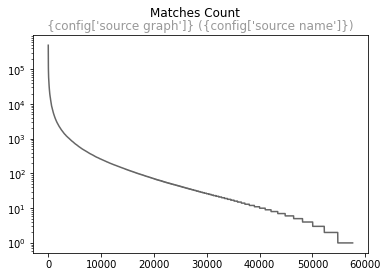

In [4]:
# plot how matches distribute over entities

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

from irt2.sampling import EID, Mention


def plot_dist(
    y,
    title: str,
    subtitle: str,
    filenames: list[Path] = None,
):
    fig, ax = plt.subplots()
    fig.suptitle(title)

    ax.set_title(subtitle, color='#999')
    ax.set_yscale('log')

    ax.plot(np.arange(len(y)), y, color='#666')

    if filenames:
        for filename in filenames:
            fig.savefig(filename)


def plot_distribution_idx(index, **kwargs):

    lens = {}
    for eid in index.keys('eid'):
        n = len(index.dis(eid=eid))
        lens[eid] = n

    lens = sorted(((n, eid) for eid, n in lens.items()), reverse=True)
    y = np.array([n for n, _ in lens])

    plot_dist(y=y, **kwargs)
    return y


cde_y = plot_distribution_idx(
    index=idx_matches,
    title="Matches Count",
    subtitle="{config['source graph']} ({config['source name']})",
    # filenames=[
    #     ... / f'irt.cde.matches-distribution.{suff}'
    #     for suff in ('png', 'svg')
    # ],
)

In [5]:
print(f"\nmapping EIDS to mentions")
print(f"pruning at threshold: {config['prune mentions']}")

mentions: dict[EID, dict[Mention, int]]
norm2mentions: dict[str, str]

norm2mentions, mentions = sampling.get_mentions(
    index=idx_matches,
    prune=config['prune mentions'],
)

print(f'retained {len(mentions)} mentions')


mapping EIDS to mentions
pruning at threshold: 5


retained 57614 mentions


In [6]:
# some example mentions

def print_mention_counts(mentions, eid):
    for mention, count in sorted(mentions[eid].items(), key=lambda t: t[1], reverse=True):
        print(f"{count:5d} {mention}" )
    print()


print_mention_counts(mentions=mentions, eid='Q11708')
print_mention_counts(mentions=mentions, eid='Q49297')
print_mention_counts(mentions=mentions, eid='Q21077')

10036 southeast asia
  165 southeast
  125 south east asia
   32 southeast asian
   19 south east asian
   14 southeast asian countries
   13 southeastern asia
    9 southeast asian region
    8 sea
    5 south east
    5 southeastern

 9807 native american
 5211 native americans
 1640 indian
 1272 indians
 1106 american indian
  620 native
  424 american indians
  114 native americans in the united states
  106 american
   49 natives
   48 indigenous
   36 native american tribes
   34 indigenous peoples
   30 indian tribes
   24 united states
   22 tribe
   20 indigenous people
   18 native peoples
   16 tribal
   14 native american tribe
   12 american indian or alaska native
   10 native american people
   10 native american peoples
    9 indian affairs
    9 aboriginal american
    9 native american indians
    8 american indian and alaska native
    7 native tribes
    7 native indian
    7 tribes
    7 native indians
    6 native american indian
    6 first nations
    6 bands
  

In [7]:
# entities with most mentions
for eid, mdic in sorted(mentions.items(), key=lambda t: len(t[1]), reverse=True)[:20]:
    print(len(mdic), eid, list(idx_matches.get(eid=eid))[0].entity)

59 Q7318 Nazi Germany
55 Q30 United States of America
47 Q129286 British Raj
45 Q36747 Indigenous peoples of America
42 Q8680 British Empire
39 Q12560 Ottoman Empire
39 Q2415901 Allied-occupied Germany
38 Q193714 Mandatory Palestine
38 Q131359 professional wrestling
37 Q49297 Indigenous peoples of the United States
37 Q38903 Universal Music Group
37 Q21077 Warner Music Group
36 Q9592 Catholic Church
36 Q2277 Roman Empire
36 Q12544 Byzantine Empire
35 Q35032 Eastern Orthodox Church


33 Q2736 association football


33 Q145 United Kingdom
31 Q34266 Russian Empire
30 Q15180 Soviet Union


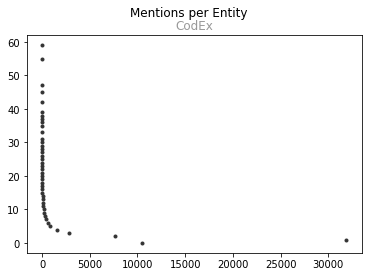

In [8]:
from collections import Counter


def plot_mention_counts(mentions, title, subtitle, **kwargs):
    counts = Counter()
    for countdic in mentions.values():
        counts[len(countdic)] += 1

    y, x = zip(*sorted(counts.items()))

    fig, ax = plt.subplots()
    fig.suptitle(title)
    ax.set_title(subtitle, color='#999')

    ax.scatter(x, y, **kwargs)



plot_mention_counts(
    mentions=mentions,
    title="Mentions per Entity",
    subtitle=config['source name'],
    color='#333',
    marker='.',
)

In [9]:
from irt2.graph import Graph
from irt2.graph import load_graph


graph = load_graph(
    config['graph loader'],
    config['graph name'],
    *[irt2.ENV.DIR.ROOT / path for path in config['graph loader args']],
    **{k: irt2.ENV.DIR.ROOT / path for k, path in config['graph loader kwargs'].items()},
)


print(graph.description)

IRT2 GRAPH: CodEx-M
  nodes: 17050
  edges: 206205 (51 types)
  degree:
    mean 24.19
    median 13



In [65]:
# plan:
#  - select all mentions of concept entities
#  - shuffle and split remaining mentions randomly
#  - assign vertices based on mention split to be either cw or ow
#  - assign triples based on vertex split


import random
from irt2.types import VID
from irt2.graph import Relation
from ktz.collections import unbucket


# select all concept entities
def split_mentions(
        graph: Graph,
        mentions: dict[EID, dict[Mention]],
        seed: int,
        ratio: float,
        concept_rels: list[str], # manually selected concept relations
        include_rels: list[str], # upstream names
        exclude_rels: list[str], # upstream names
):
    assert not include_rels and exclude_rels, "mutex!"

    relations = Relation.from_graph(graph)
    print(f'loaded {len(relations)} relations')

    # apply include/exclude

    includes = set(include_rels)
    assert len(includes) == len(include_rels)

    excludes = set(exclude_rels)
    assert len(excludes) == len(exclude_rels)

    if includes:
        relations = [rel for rel in relations if rel.name in includes]

    elif excludes:
        relations = [rel for rel in relations if rel.name not in excludes]

    print(f'after applying filter: {len(relations)} relations remain')
    assert relations

    # set aside concept entities

    concept_rels = set(concept_rels)
    concept_entities = set.union(*[
        rel.concepts for rel in relations if rel.name in concept_rels
    ])

    print(f'selected {len(concept_entities)} concept entities from {len(concept_rels)} relations')
    assert concept_entities

    # split mentions

    Flat = set[tuple[VID, Mention]]

    closed: Flat = set()
    open: Flat = set()
    candidates: Flat = set()
    removed: dict[VID, EID] = set()

    print('retaining closed world mentions')
    for vid, eid in graph.source.ents.items():

        # map to upstream
        # Q108946:A Few Good Men -> Q108946
        link = eid.split(':')[0]
        if link not in mentions:
            removed.add((vid, eid))
            continue

        # create a flat list to be split later
        flat = {(vid, mention) for mention in mentions[link].keys()}
        if vid in concept_entities:
            closed |= flat
        else:
            candidates |= flat

    print(f'  set aside {len(closed)}/{len(closed) + len(candidates)} mentions as concepts')
    print(f'  removed {len(removed)}/{len(graph.source.ents)} vertices without mentions')

    print('retaining open world mentions')

    random.seed(seed)
    candidates = sorted(candidates)
    random.shuffle(candidates)

    total = len(closed) + len(candidates)
    split = int(ratio * total)

    assert split > len(closed)
    open = set(candidates[:split])
    closed |= set(candidates[split:])

    assert not open & closed

    print(f'  closed-world: {len(closed)} mentions')
    print(f'  open-world: {len(open)} mentions')


split_mentions(
    graph,
    mentions=mentions,
    seed=config['seed'],
    ratio=config['target mention split'],
    concept_rels=config['concept relations'],
    include_rels=config['include relations'],
    exclude_rels=config['exclude relations'],
)

loaded 51 relations
after applying filter: 46 relations remain
selected 2489 concept entities from 27 relations
retaining closed world mentions
  set aside 12779/32666 mentions as concepts
  removed 877/17050 vertices without mentions
retaining open world mentions
  closed-world: 16333 mentions
  open-world: 16333 mentions


In [29]:
# distribute vids between open and closed world based on 
# eid2vid = {v.split(':')[0]: k for k, v in g.source.ents.items()}